 In this notebook I train a Random Forest model to predict which class [quarry blast, earthquake, or MIS] an event belongs to based on 12 features computed by Keith and Relu. I did not do any hyperparameter tuning beyond exploring the `class_weight` option. It is clear the models are overfitting slightly and I may need to use fewer trees. Also, I quickly try removing some correlated features using a dendrogram.

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay

# Load in the data

In [2]:
original_data = pd.read_csv("../data/delivery.2023.03.12.dat", sep="\s+")

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_841755/451832599.py:1: SyntaxWarning: invalid escape sequence '\s'
  original_data = pd.read_csv("../data/delivery.2023.03.12.dat", sep="\s+")


In [3]:
original_data.head()

,Date,Time,Lat,Lon,Dep,Tag,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12
0,2012-10-02,18:49:25.22,40.514,-112.161,-2.0,ex,0.00,0.24,0.25,-83.6,-116.6,14.61,12.41,-0.37,0.01,-0.01,0.18,0.44
1,2012-10-05,21:37:54.01,40.495,-112.156,-2.0,ex,-0.29,0.34,0.27,-77.6,-126.8,13.24,12.36,-0.20,-0.19,0.12,0.06,0.36
2,2012-10-07,16:59:31.79,40.531,-112.161,-2.0,ex,-0.03,0.89,0.60,-91.1,-111.6,12.21,11.88,-0.10,0.04,0.16,-0.11,0.12
3,2012-10-07,21:27:49.76,40.519,-112.165,-2.0,ex,-0.16,0.15,0.12,-85.5,-114.8,13.33,12.37,-0.51,-0.20,-0.26,0.36,0.55
4,2012-10-09,22:55:46.02,40.494,-112.186,-2.0,ex,-0.22,0.35,0.11,-67.2,-103.5,14.08,12.97,-0.14,-0.06,0.09,0.35,0.42


In [4]:
# Look at the ranges of the values
original_data.describe()

,Lat,Lon,Dep,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12
count,1321.000000,1321.000000,1321.000000,1321.000000,1321.000000,1321.000000,1321.000000,1321.000000,1321.000000,1321.000000,1321.000000,1321.000000,1321.000000,1321.000000,1321.000000
mean,39.848418,-111.784780,5.691582,-0.083785,0.375026,0.317479,-107.148297,-119.706056,15.235511,14.754784,-0.467517,-0.360643,-0.298032,0.165004,0.327487
std,1.246586,1.010628,6.927491,0.248041,0.352944,0.321559,18.825199,18.197792,1.178096,0.994258,0.172655,0.175630,0.198478,0.215352,0.219393
min,36.773000,-114.021000,-3.340000,-1.520000,-0.890000,-1.310000,-170.700000,-183.900000,11.860000,11.460000,-0.990000,-0.990000,-0.990000,-0.330000,-0.140000
25%,39.410000,-112.196000,-1.560000,-0.260000,0.170000,0.120000,-119.600000,-131.600000,14.250000,14.310000,-0.580000,-0.470000,-0.420000,0.000000,0.160000
50%,40.493000,-112.056000,7.040000,-0.040000,0.410000,0.340000,-107.700000,-121.400000,15.440000,14.970000,-0.470000,-0.370000,-0.310000,0.130000,0.280000
75%,40.746000,-111.323000,9.850000,0.080000,0.610000,0.530000,-94.200000,-108.100000,16.180000,15.410000,-0.370000,-0.260000,-0.200000,0.320000,0.470000
max,42.424000,-108.894000,55.750000,1.450000,2.730000,2.040000,-44.600000,-64.100000,17.790000,17.700000,0.470000,0.410000,0.420000,1.030000,1.220000


In [5]:
original_data['Tag'].value_counts()

Tag
eq     814
ex     279
mis    228
Name: count, dtype: int64

# Get the features and labels

In [9]:
feature_col_names = ['F1', 'F2', 'F3', 'F4',
                    'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12']
X_df = original_data[feature_col_names].astype(float)

In [10]:
X_df.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12
0,0.00,0.24,0.25,-83.6,-116.6,14.61,12.41,-0.37,0.01,-0.01,0.18,0.44
1,-0.29,0.34,0.27,-77.6,-126.8,13.24,12.36,-0.20,-0.19,0.12,0.06,0.36
2,-0.03,0.89,0.60,-91.1,-111.6,12.21,11.88,-0.10,0.04,0.16,-0.11,0.12
3,-0.16,0.15,0.12,-85.5,-114.8,13.33,12.37,-0.51,-0.20,-0.26,0.36,0.55
4,-0.22,0.35,0.11,-67.2,-103.5,14.08,12.97,-0.14,-0.06,0.09,0.35,0.42


In [11]:
# LabelEncoder will transform the class names to numeric values
le = LabelEncoder()
le.fit(original_data['Tag'])
print("Original Classes", le.classes_)
print("Mapping", le.transform(le.classes_))
le.classes_ = np.array(['ex', 'eq', 'mis'])
print("Updated Classes", le.classes_)
print("Mapping", le.transform(le.classes_))
y = le.transform(original_data['Tag'])
y_cnts = np.unique(y, return_counts=True)[1]
print(y_cnts)

Original Classes ['eq' 'ex' 'mis']
Mapping [0 1 2]
Updated Classes ['ex' 'eq' 'mis']
Mapping [0 1 2]
[279 814 228]


# Do a simple 80/20 train/test split

In [12]:
train_inds, test_inds = train_test_split(np.arange(X_df.shape[0]), test_size=0.2, shuffle=True, random_state=42)

In [13]:
X_df = X_df.to_numpy()
X_train = X_df[train_inds]
X_test = X_df[test_inds]
y_train = y[train_inds]
y_test = y[test_inds]

In [14]:
print('Training:', X_train.shape, y_train.shape)
print('Testing:', X_test.shape, y_test.shape)
print("Actual class percentage:", y_cnts/len(y))
print('Training class percentage:', np.unique(y_train, return_counts=True)[1]/len(y_train))
print('Testing class percentage:', np.unique(y_test, return_counts=True)[1]/len(y_test))

Training: (1056, 12) (1056,)
Testing: (265, 12) (265,)
Actual class percentage: [0.21120363 0.61619985 0.17259652]
Training class percentage: [0.20359848 0.61647727 0.17992424]
Testing class percentage: [0.24150943 0.61509434 0.14339623]


# Set up a stratified 10-fold cross-validation with 3 repeats 
Doing this for if/when I need to do hyperparmeter tuning

In [15]:
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=36851234)

### Quickly look at the effect of using `class_weight` = `balanced_subsample`, `balanced`, and `None`
This parameter influences the weight of each class. In `balanced`, the weights are inversely proportional to the class frequency in the training set. In `balanced_subsample` the weights are determined from the bootstrap sample of every tree. None means all classes have the same weight. 

This parameter did not seem to matter much and using `None` actually preformed marginally better. 

I am using F1 score, which is the harmonic mean of precision and recall, to estimate model performance here. `averaging="macro"` means that the F1 score for each of the classes is simply averaged. I chose this because I care about all the classes equally and don't want to give more weight to eq (majority class).

In [16]:
rf = RandomForestClassifier(n_estimators=1000, random_state=0, class_weight='balanced_subsample')
cv_results_balanced_subsample = cross_validate(rf, X_train, y_train, cv=rskf, scoring='f1_macro')

In [17]:
print(cv_results_balanced_subsample['test_score'].mean(), cv_results_balanced_subsample['test_score'].std())

0.9660430992798593 0.02041022729751742


In [18]:
rf = RandomForestClassifier(n_estimators=1000, random_state=0, class_weight='balanced')
cv_results_balanced = cross_validate(rf, X_train, y_train, cv=rskf, scoring='f1_macro')
print(cv_results_balanced['test_score'].mean(), cv_results_balanced['test_score'].std())

0.967212711189454 0.020964364672428557


In [19]:
rf = RandomForestClassifier(n_estimators=1000, random_state=0, class_weight=None)
cv_results_unbalanced = cross_validate(rf, X_train, y_train, cv=rskf, scoring='f1_macro')
print(cv_results_unbalanced['test_score'].mean(), cv_results_balanced['test_score'].std())

0.9703915462284892 0.020964364672428557


# Train/test one model with `class_weight`=None
Doing this to be able to easily compute a confusion matrix and estimate feature importance. I probably could save all the classifiers during CV, get the estimated feature importance, and combine somehow. 

In [21]:
rf = RandomForestClassifier(n_estimators=1000, random_state=0, class_weight=None)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=0)

In [24]:
y_pred_test = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test)
print(cm)

[[ 64   0   0]
 [  1 162   0]
 [  0   0  38]]


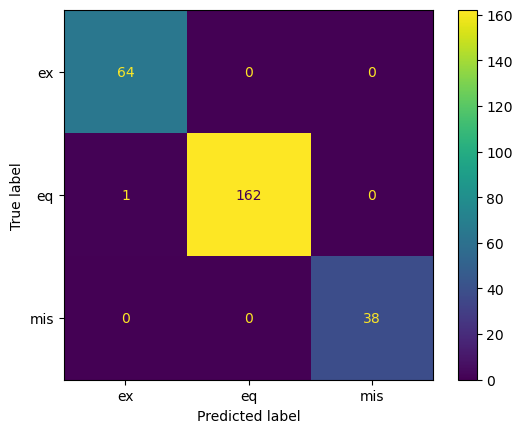

In [25]:
display = ConfusionMatrixDisplay(confusion_matrix=cm, 
                       display_labels=le.classes_)
display.plot()

## F1 score = 1.0 on training set => possible overfitting

Though testing performance is also quite high...

In [60]:
y_pred_train = rf.predict(X_train)
f1_score(y_train, y_pred_train, average='macro')

1.0

In [58]:
f1_score(y_test, y_pred_test, average='macro')

0.9963903796461936

# Look at training feature importance
Copied this example:  
https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

### Feature importance from the Mean Decrease in Impurity (aka Gini importance)
This is computed by the Random Forest automatically. "The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature". This might not be the best option for continuous features (high cardinality)... 

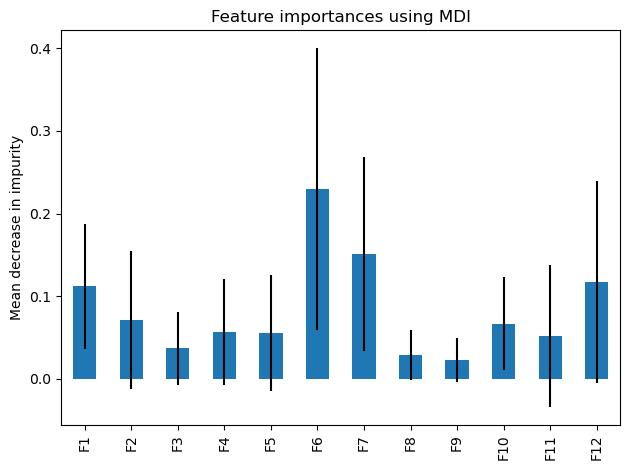

In [30]:
forest_importances = pd.Series(rf.feature_importances_, index=feature_col_names)
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Feature importance based on feature permutation
For each feature, the values are shuffled *10* times and the model is reevaluated. The feature importance is the difference between the baseline score (no permuations) and the score when permuting the feature. The feature importance is averaged of the *10* repeates. This method is not biased by high cardinality features but it effected by correlated features. If two features are highly correlated, then the information is not removed from the model when permuting one of them.

In [33]:
from sklearn.inspection import permutation_importance
import time 

start_time = time.time()
result = permutation_importance(
    rf, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_col_names)

Elapsed time to compute the importances: 16.539 seconds


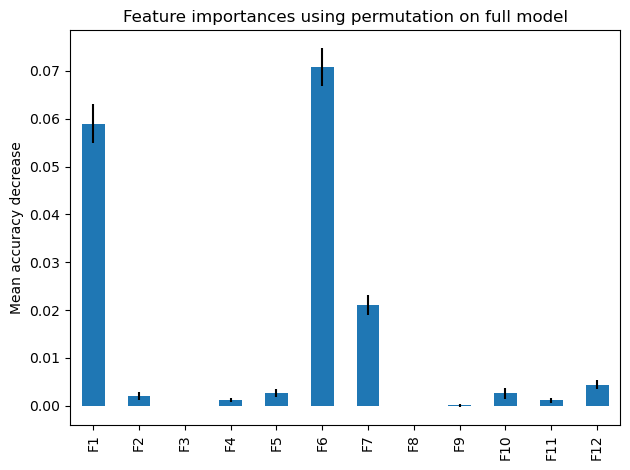

In [34]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

# Take into account multicollinear features before estimating feature importance

Copied this example:  
https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py

### Perform heirarchical clustering of the features using Spearman rank-order correlations

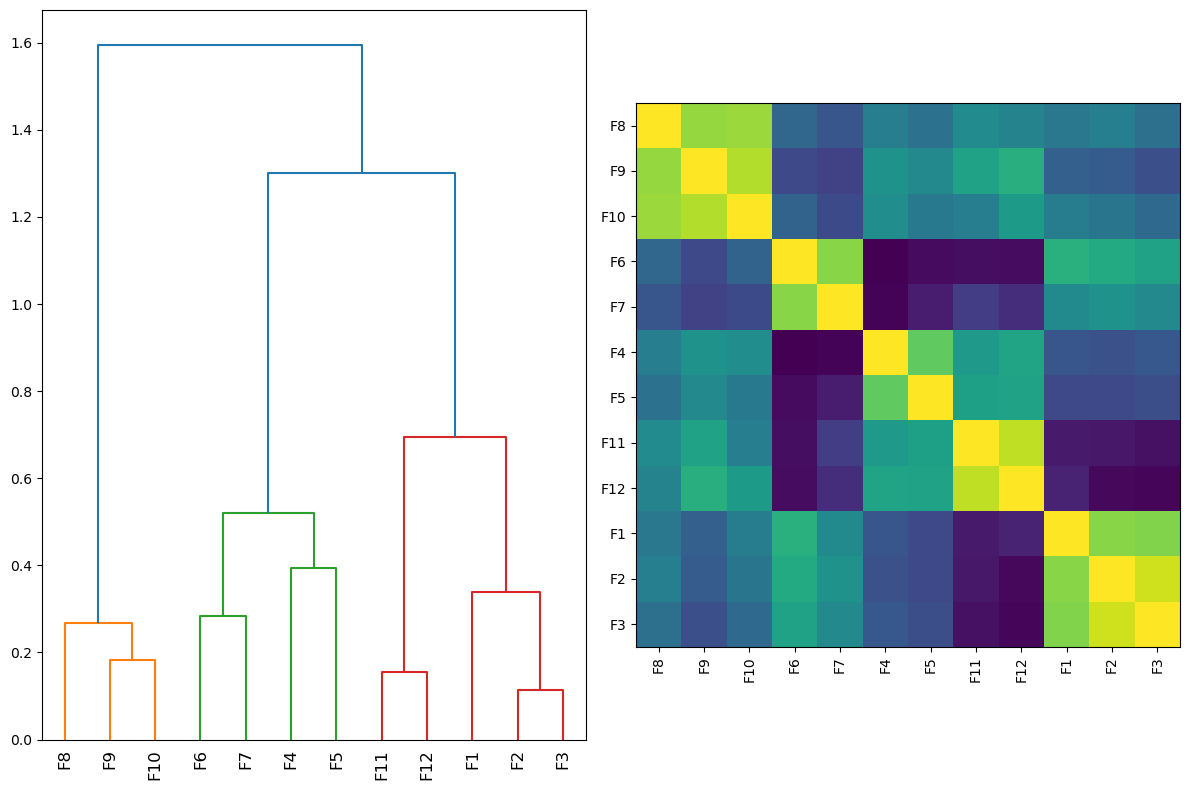

In [36]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X_df).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=feature_col_names, ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
_ = fig.tight_layout()

### Pick 0.5 as a threshold and keep one feature from each cluster
Then, retrain the model with just the 5 features

In [61]:
from collections import defaultdict

cluster_ids = hierarchy.fcluster(dist_linkage, 0.5, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

X_train_sel = X_train[:, selected_features]
X_test_sel = X_test[:, selected_features]
print(X_train_sel.shape, X_test_sel.shape)
clf_sel = RandomForestClassifier(n_estimators=1000, random_state=0, class_weight=None)
clf_sel.fit(X_train_sel, y_train)

(1056, 5) (265, 5)


RandomForestClassifier(n_estimators=1000, random_state=0)

### These are the 5 kept features

In [62]:
np.array(feature_col_names)[selected_features]

array(['F1', 'F4', 'F6', 'F8', 'F11'], dtype='<U3')

### Now look at feature importance of the 5 features (values are larger than before)

Elapsed time to compute the importances: 11.365 seconds


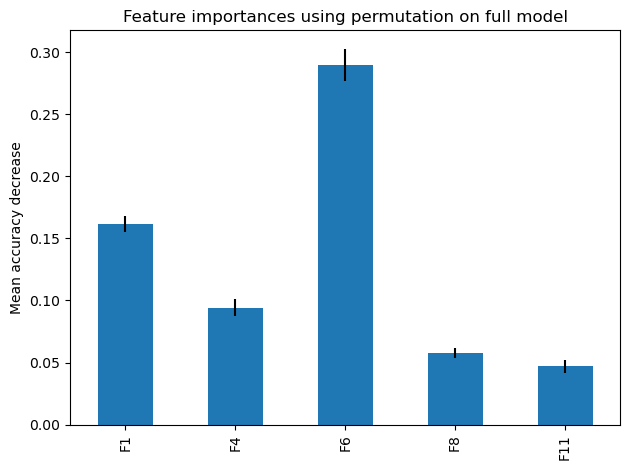

In [63]:
start_time = time.time()
result = permutation_importance(
    clf_sel, X_train_sel, y_train, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=np.array(feature_col_names)[selected_features])

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

### Model performance did decrease on the test set and looks like overfitting is a problem here

In [66]:
y_pred_train_sel = clf_sel.predict(X_train_sel)
f1_score(y_train, y_pred_train_sel, average='macro')

1.0

In [65]:
f1_score(y_test, clf_sel.predict(X_test_sel), average='macro')

0.8998534030005313